In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from pathlib import Path
import json
import pickle
import numpy as np
import torch as T
import torch.nn as nn
import matplotlib.pyplot as plt
from src.models.decision_transformer import DecisionTransformer
from src.evaluation.evaluate import evaluate_model_batched


In [2]:
# Set up device
device = T.device('cuda' if T.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    np.random.seed(seed)
    T.manual_seed(seed)
    if T.cuda.is_available():
        T.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda


# Experimentos de return conditioning 

In [5]:
# Rutas
test_path = "../data/test_users/netflix8_test.json"

final_model_path = "../results/trained_models/trained_model.pt"
reference_model_path = "../reference_code/trained_model_reference.pt"

# Cargar usuarios de test
with open(test_path, "r") as f:
    test_users = json.load(f)
    
# Cargar trayectorias de entrenamiento normalizadas
train_trajectories_path = "../data/processed/trajectories_train.pkl"
with open(train_trajectories_path, "rb") as f:
    train_trajectories = pickle.load(f)

In [7]:
num_items = 752
num_groups = 8
# hidden_dim = 512
hidden_dim = 256
n_layers = 2
n_heads = 4
context_length = 25
max_timesteps = 200
dropout = 0.1
batch_size = 64
num_epochs = 2000
learning_rate = 0.0001

final_model = DecisionTransformer(
    num_items=752,
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
    max_timestep=max_timesteps,
    dropout=dropout
).to('cuda')

# Cargar pesos entrenados
ckpt_path = Path(final_model_path) 
state_dict = T.load(ckpt_path, map_location=device)
final_model.load_state_dict(state_dict) 

# Preparar para inferencia
final_model.to(device)
final_model.eval()

print("Modelo cargado desde:", ckpt_path)

final_model_metrics = evaluate_model_batched(
    model=final_model,
    test_data=test_users,
    device=device,
    target_return=None,
    k_list=(5, 10, 20),
    context_len=20,
    eval_batch_size=1024,
)

C:\Users\SudokuX\AppData\Local\Temp\ipykernel_30616\4088997379.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = T.load(ckpt_path, map_location=device)


Modelo cargado desde: ..\results\trained_models\trained_model.pt


Percentiles:
  p25: 213.00
  p50: 350.00
  p75: 497.00
  p90: 604.00
  max: 849.00

Evaluando con target_return = p25 (R=213.00)...
  HR@10   = 0.0157
  NDCG@10 = 0.0071
  MRR     = 0.0103

Evaluando con target_return = p50 (R=350.00)...
  HR@10   = 0.0154
  NDCG@10 = 0.0070
  MRR     = 0.0103

Evaluando con target_return = p75 (R=497.00)...
  HR@10   = 0.0154
  NDCG@10 = 0.0070
  MRR     = 0.0103

Evaluando con target_return = p90 (R=604.00)...
  HR@10   = 0.0154
  NDCG@10 = 0.0070
  MRR     = 0.0103

Evaluando con target_return = max (R=849.00)...
  HR@10   = 0.0154
  NDCG@10 = 0.0070
  MRR     = 0.0103


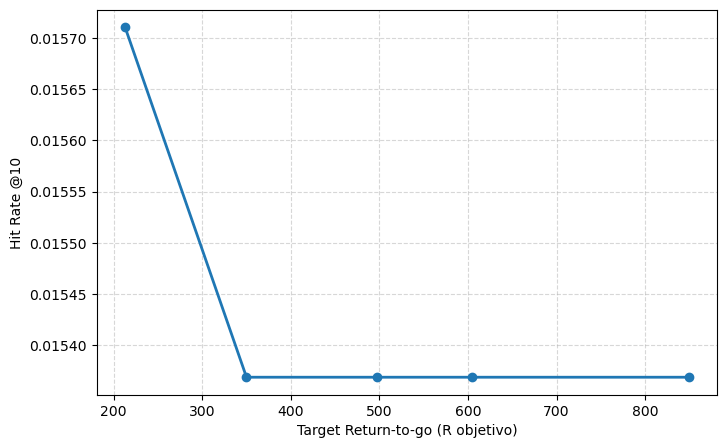

In [9]:
#Experimentos con valores de return to go
# Usamos train_trajectories y test_users que ya cargamos arriba.
trajectories = train_trajectories
test_data = test_users

# calcular percentiles de returns en training con numpy y los da en un diccionario
train_returns = [traj['returns_to_go'][0] for traj in trajectories]

percentiles = {
    'p25': np.percentile(train_returns, 25),
    'p50': np.percentile(train_returns, 50),
    'p75': np.percentile(train_returns, 75),
    'p90': np.percentile(train_returns, 90),
    'max': np.max(train_returns)
}

print("Percentiles:")
for name, value in percentiles.items():
    print(f"  {name}: {value:.2f}")


results = {}
for name, rtg_value in percentiles.items():
    print(f"\nEvaluando con target_return = {name} (R={rtg_value:.2f})...")
    metrics = evaluate_model_batched(
        model=final_model,
        test_data=test_data,
        device=device,
        target_return=rtg_value  # k_list usa el default [5, 10, 20]
    )
    results[name] = metrics

    print(f"  HR@10   = {metrics['HR@10']:.4f}")
    print(f"  NDCG@10 = {metrics['NDCG@10']:.4f}")
    print(f"  MRR     = {metrics['MRR']:.4f}")

# Graficar Return objetivo vs HR@10
rtg_values = list(percentiles.values())
hr10_values = [results[name]['HR@10'] for name in percentiles.keys()]

plt.figure(figsize=(8, 5))
plt.plot(rtg_values, hr10_values, marker='o', linewidth=2)
plt.xlabel('Target Return-to-go (R objetivo)')
plt.ylabel('Hit Rate @10')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [10]:
# Usamos el percentil 75 de R_0 como target_return para todos los grupos porque alguno hay que usar. 
target_rtg_group = percentiles['p75'] #se puede hacer con otro si se cambia aca el percentil que se usa

results_by_group = {}

for group_id in range(8):
    # hacemos un if para sacar los usuarios que pertenecen al grupo encuestión
    users_in_group = [u for u in test_users if u['group'] == group_id]
    metrics = evaluate_model_batched(
        model=final_model,
        test_data=users_in_group,
        device=device,
        target_return=target_rtg_group,
        k_list=[5, 10, 20]
    )
    results_by_group[group_id] = metrics

    #aca lo cambié para que imprima toda las métricas 
    print(f"  HR@10   = {metrics['HR@10']:.4f}")
    print(f"  NDCG@10 = {metrics['NDCG@10']:.4f}")
    print(f"  MRR     = {metrics['MRR']:.4f}\n")

  HR@10   = 0.0123
  NDCG@10 = 0.0055
  MRR     = 0.0095

  HR@10   = 0.0150
  NDCG@10 = 0.0067
  MRR     = 0.0097

  HR@10   = 0.0232
  NDCG@10 = 0.0099
  MRR     = 0.0116

  HR@10   = 0.0164
  NDCG@10 = 0.0075
  MRR     = 0.0106

  HR@10   = 0.0123
  NDCG@10 = 0.0065
  MRR     = 0.0104

  HR@10   = 0.0150
  NDCG@10 = 0.0065
  MRR     = 0.0098

  HR@10   = 0.0150
  NDCG@10 = 0.0079
  MRR     = 0.0117

  HR@10   = 0.0137
  NDCG@10 = 0.0057
  MRR     = 0.0092

